# Investigate a Dataset: TMDb Movie Data

### Author: Lucas Belpaire

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This is the second project of Udacity's 'Data Analyst' Nanodegree. The goal of this project is to conduct my own data analysis and report my findings. I have chosen the TMDb Movie Dataset for this project. This dataset has a lot of columns, and I won't use all of them in this report. Columns such as id, imdb_id, original_title, cast, homepage, genres, etc., are not usefull for the questions that will be answered.

The values of the original budget_adj and revenue_adj columns will be replaced by newly calculated values that are adjusted for 2018. A python script I wrote will perform these calculations.

The following columns will be used in the data analysis:

**budget** The budget of the movie in dollars.

**revenue** The revenue of the movie in dollars.

**budget_adj** The budget of the movie in dollars, adjusted for inflation (in terms of 2018).

**revenue_adj** The revenue of the movie in dollars, adjusted for inflation (in terms of 2018).

**runtime** The runtime of the movie in minutes.

**release_date** The release date of the movie in the MM/DD/YY format. The date is saved as a String object.

**vote_count** The amount of votes the movie got.

**vote_average** The average score the movie got. Max. score is 10, Min. score is 0.

**release_year** The year of the movies release.

The following questions will be answered in this report:
1. Does the average budget increase as time increases? By how much? When adjusting the budget for inflation, does it still increase in time?
2. Is there a positive correlation between budget and average score? Is there between budget and popularity?
3. What kind of properties are associated with highly popular movies?

In [1]:
#Libraries used in this notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import inflationcalculatorv2 as inf

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
# The csv file gets read into a pandas dataframe variable.
df_movie = pd.read_csv('tmdb-movies.csv')

### Data Cleaning
As said in the introduction some columns won't be used in this analysis. These columns will be dropped in the first step of the data cleaning process.
In the second step we will change the datatype of some columns so they can be worked with more easily.
In the third step we will take a look at missing values and determine what we will do with them.

In [3]:
# Code for dropping columns. We will drop the columns by name.
columns_to_be_dropped = ['id', 'imdb_id', 'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview', 'production_companies', 'budget_adj', 'revenue_adj']
df_movie_clean = df_movie.drop(columns_to_be_dropped, axis=1)
df_movie_clean.head()

,popularity,budget,revenue,original_title,runtime,genres,release_date,vote_count,vote_average,release_year
0,32.985763,150000000,1513528810,Jurassic World,124,Action|Adventure|Science Fiction|Thriller,6/9/15,5562,6.5,2015
1,28.419936,150000000,378436354,Mad Max: Fury Road,120,Action|Adventure|Science Fiction|Thriller,5/13/15,6185,7.1,2015
2,13.112507,110000000,295238201,Insurgent,119,Adventure|Science Fiction|Thriller,3/18/15,2480,6.3,2015
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,136,Action|Adventure|Science Fiction|Fantasy,12/15/15,5292,7.5,2015
4,9.335014,190000000,1506249360,Furious 7,137,Action|Crime|Thriller,4/1/15,2947,7.3,2015


Let's inspect the remaining columns using the info and describe function.

In [4]:
df_movie_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 10 columns):
popularity        10866 non-null float64
budget            10866 non-null int64
revenue           10866 non-null int64
original_title    10866 non-null object
runtime           10866 non-null int64
genres            10843 non-null object
release_date      10866 non-null object
vote_count        10866 non-null int64
vote_average      10866 non-null float64
release_year      10866 non-null int64
dtypes: float64(2), int64(5), object(3)
memory usage: 849.0+ KB


Using the info function it is clear that only the genres collumn is missing values. Because the amount of rows that miss these values is insignificant these rows will be dropped.

All columns, except for release_date, have the correct data types. We will change the datetype of the release_date column later on.

In [5]:
df_movie_clean.dropna(axis=0, inplace=True)

In [6]:
df_movie_clean.describe()

,popularity,budget,revenue,runtime,vote_count,vote_average,release_year
count,10843.000000,1.084300e+04,1.084300e+04,10843.000000,10843.000000,10843.000000,10843.000000
mean,0.647456,1.465672e+07,3.990779e+07,102.137508,217.813705,5.973974,2001.315595
std,1.000986,3.093864e+07,1.171131e+08,31.293320,576.155351,0.934260,12.813298
min,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000
25%,0.208253,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000
50%,0.384555,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000
75%,0.715349,1.500000e+07,2.413675e+07,111.000000,146.000000,6.600000,2011.000000
max,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000


When inspecting the results of the describe function we can see that several columns have a minimum value of zero. These are the budget, revenue and runtime column. As each of these columns can't be zero, they need to be examined more closely so we can decide how to handle them.

In [7]:
df_movie_clean[(df_movie_clean.budget == 0)].count()

popularity        5674
budget            5674
revenue           5674
original_title    5674
runtime           5674
genres            5674
release_date      5674
vote_count        5674
vote_average      5674
release_year      5674
dtype: int64

Over half the movies have a budget 0, so there is a lot of data missing in this dataset. There are two ways to handle this. All movies with a budget of 0 could be removed, or we could replace these 0 values with the value of the mean.

Because replacing the values with the mean could wrongly influence results, especially affecting the budget of older movies. I have decided to drop all rows with a value of zero.

In [8]:
df_movie_clean = df_movie_clean[(df_movie_clean != 0).all(1)]
df_movie_clean.reset_index(inplace=True) # a lot of rows get deleted, every row gets a new index

The original dataset had the columns budget_adj and revenue_adj. Because these were incomplete and not up to date they were removed. I wrote a little python script that calculates the values for these columns adjusted for 2018. 

In [9]:
df_movie_clean['budget_adj'] = df_movie_clean.apply(inf.calc_inflation_budget, axis=1)
df_movie_clean['revenue_adj'] = df_movie_clean.apply(inf.calc_inflation_revenue, axis=1)

In our last step of the data cleaning process we will change the datatype of the release_date column.
The datatype is currently a string, it will be converted to datetime.

In [10]:
df_movie_clean['release_date'] = pd.to_datetime(df_movie_clean['release_date'])

In [11]:
df_movie_clean.tail()

,index,popularity,budget,revenue,original_title,runtime,genres,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
3850,10822,0.670274,7500000,33736689,Who's Afraid of Virginia Woolf?,131,Drama,2066-06-21,74,7.5,1966,5.780769e+07,2.600320e+08
3851,10828,0.402730,3000000,13000000,Torn Curtain,128,Mystery|Thriller,2066-07-13,46,6.3,1966,2.312308e+07,1.002000e+08
3852,10829,0.395668,4653000,6000000,El Dorado,120,Action|Western,2066-12-17,36,6.9,1966,3.586389e+07,4.624615e+07
3853,10835,0.299911,12000000,20000000,The Sand Pebbles,182,Action|Adventure|Drama|War|Romance,2066-12-20,28,7.0,1966,9.249231e+07,1.541538e+08
3854,10848,0.207257,5115000,12000000,Fantastic Voyage,100,Adventure|Science Fiction,2066-08-24,42,6.7,1966,3.942485e+07,9.249231e+07


When inspecting the release_date column, it is clear that not all dates are parsed correctly. Python maps all values between 0–68 to 2000–2068. Because this is a problem that cannot be solved automatically and because this column isn't needed to answer our questions, the release_date column will also be dropped. 

In [12]:
df = df_movie_clean.drop('release_date',axis=1)

<a id='eda'></a>
## Exploratory Data Analysis



### Movie budget as time increases

Does the average budget increase as time increases? By how much? When adjusting the budget for inflation, does it still increase in time?

We will use a line graph to see how the average budget behaves as the years pass. If we both insert the data for the average budget and the average budget adjusted for inflation on the same plot. We will be able to easily compare the two and make the correct conclusions.

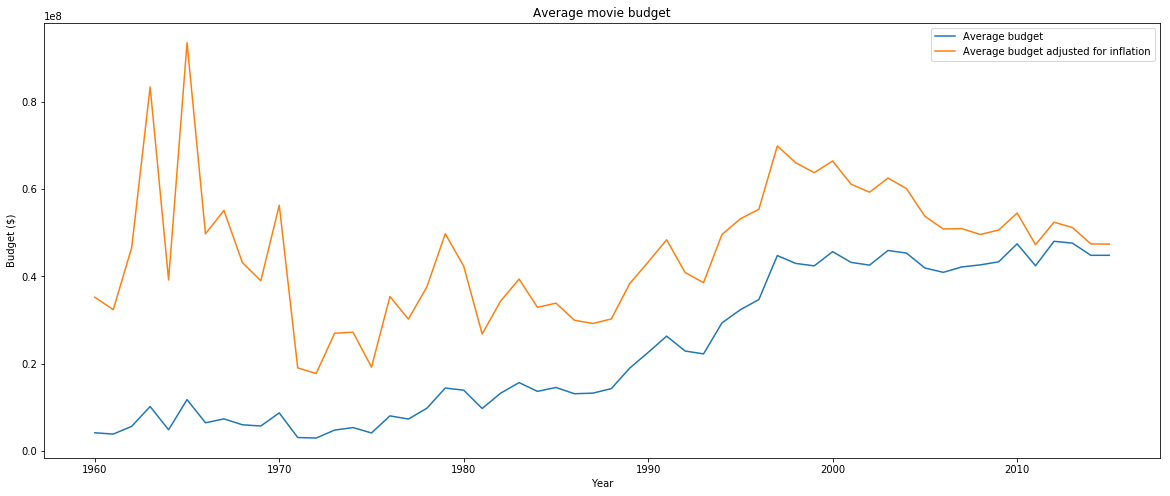

In [13]:
years = np.unique(df['release_year'].values)
average_budget = df.groupby(['release_year'])['budget'].mean()
average_budget_adj = df.groupby(['release_year'])['budget_adj'].mean()
plt.figure(figsize=(20,8))
plt.plot(years, average_budget, label="Average budget")
plt.plot(years, average_budget_adj, label="Average budget adjusted for inflation")
plt.xlabel('Year')
plt.ylabel('Budget ($)')
plt.title("Average movie budget")
corrcoef_average = np.corrcoef(years, average_budget)[1,0]
corrcoef_adj = np.corrcoef(years, average_budget_adj)[1,0]
plt.legend()
plt.show()

The correlation coefficient is a number between +1 and −1 calculated so as to represent the linear interdependence of two variables or sets of data. So we can use this coefficient to confirm if there is indeed a strong correlation between budget and release year.

In [14]:
np.corrcoef(years, average_budget)[1,0] # correlation coefficient for year and average budget

0.9380826079347033

In [15]:
np.corrcoef(years, average_budget_adj)[1,0] # correlation coefficient for year and average budget adjusted for inflation

0.2904795929285535

When looking at average budget as time increases, it could be interesting to see if the amount of movies getting made, also increases as time increases. A histogram is an ideal graph to display this data.
A histogram is a diagram consisting of rectangles whose area is proportional to the frequency of a variable and whose width is equal to the class interval.

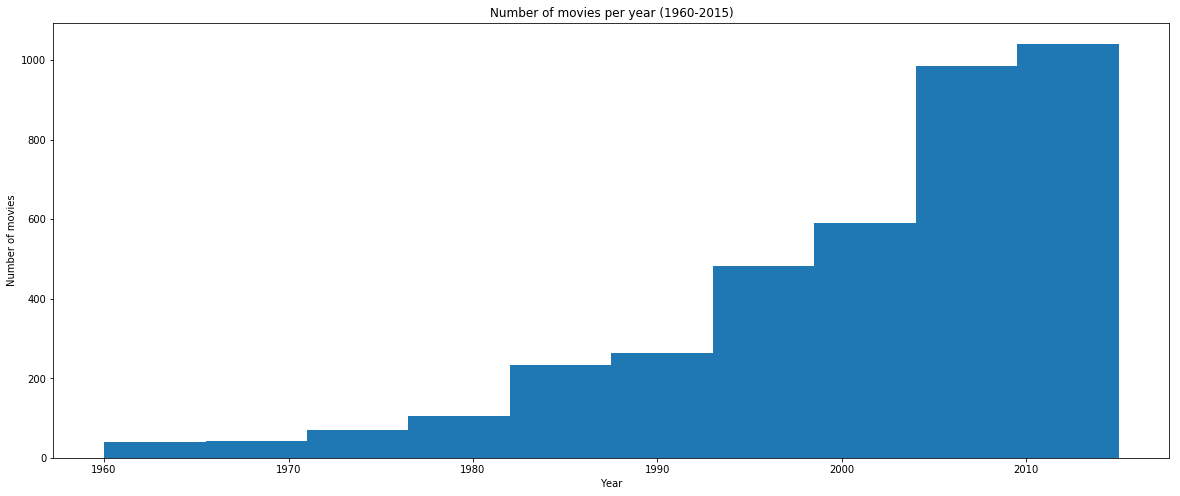

In [16]:
amount_of_movies = df['release_year']
plt.figure(figsize=(20,8))
plt.hist(amount_of_movies);
plt.title('Number of movies per year (1960-2015)')
plt.ylabel('Number of movies')
plt.xlabel('Year')
plt.show()

### Relation between popularity/score and budget.

Is there a positive correlation between budget and average score? Is there between budget and popularity?

We will use scatter plots and correlation coefficient to try to get an answer to these questions. A scatter plot is a graph in which the values of two variables are plotted along two axes, the pattern of the resulting points revealing any correlation present. Which is why a scatter plot is ideal for answering our questions.

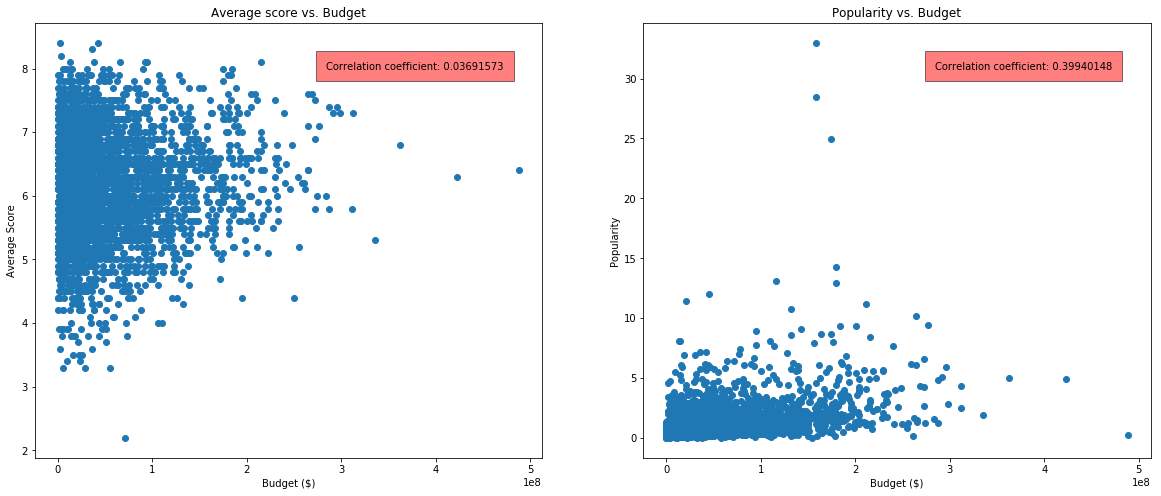

In [17]:
score = df['vote_average']
popularity = df['popularity']
budget = df['budget_adj'] # using adjusted values because it makes te comparison more fair.

corrcoef_score = np.corrcoef(budget, score)[1,0]
corrcoef_popular = np.corrcoef(budget, popularity)[1,0]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.scatter(budget, score)
ax1.set_title('Average score vs. Budget')
ax1.set_xlabel('Budget ($)')
ax1.set_ylabel('Average Score')
ax1.text(0.75, 0.9, 'Correlation coefficient: '+np.array2string(corrcoef_score),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax1.transAxes,
         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10});

ax2.scatter(budget, popularity)
ax2.set_title('Popularity vs. Budget')
ax2.set_xlabel('Budget ($)')
ax2.set_ylabel('Popularity')
ax2.text(0.75, 0.9, 'Correlation coefficient: '+np.array2string(corrcoef_popular),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax2.transAxes,
         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10});

To make our answers to the questions even more thorough we can use a histogram to get an overall view of the distribution of average voting score and popularity of a movie.

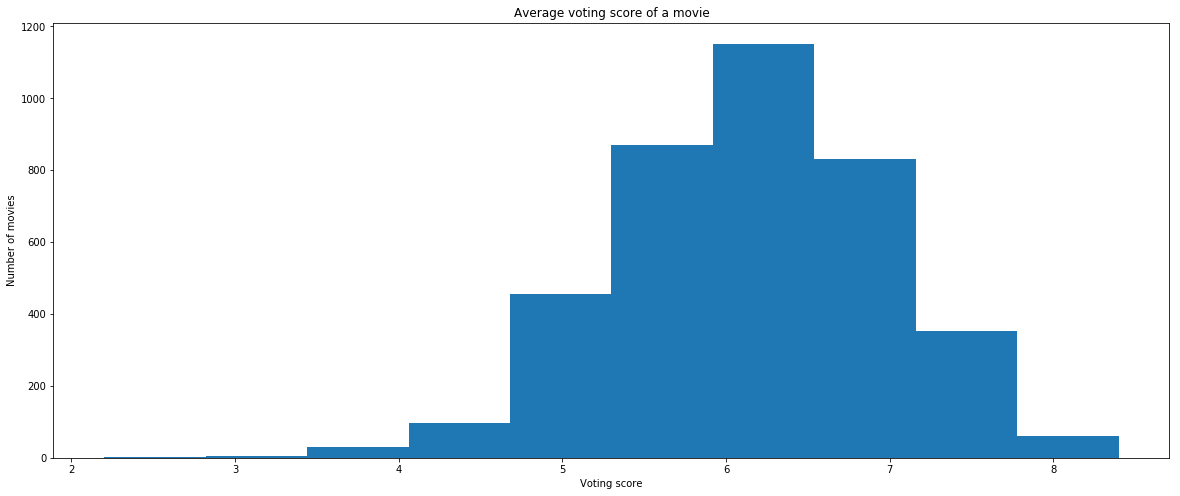

In [18]:
amount_of_movies = df['vote_average']
plt.figure(figsize=(20,8))
plt.hist(amount_of_movies);
plt.title('Average voting score of a movie')
plt.ylabel('Number of movies')
plt.xlabel('Voting score')
plt.show()

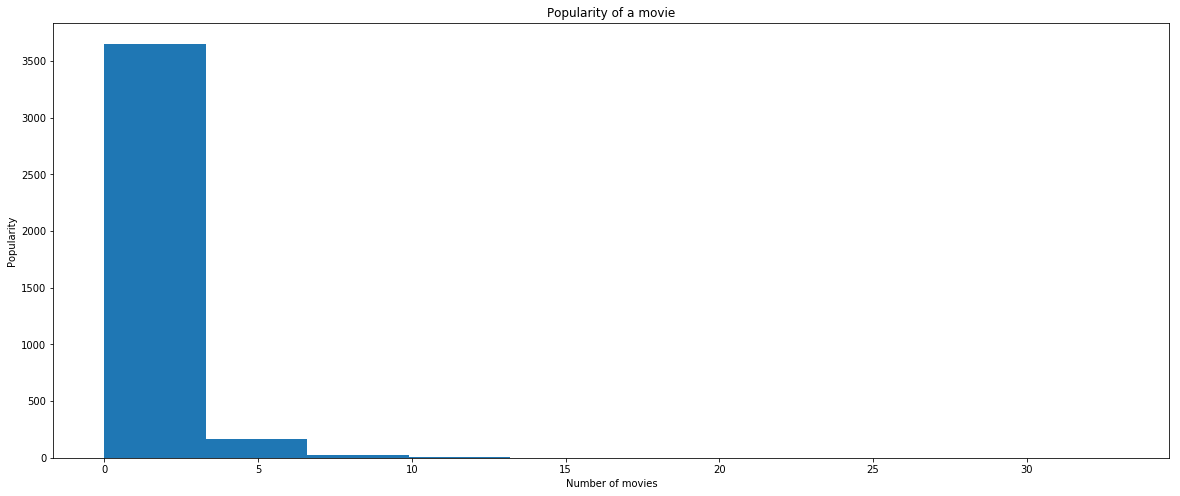

In [19]:
amount_of_movies = df['popularity']
plt.figure(figsize=(20,8))
plt.hist(amount_of_movies);
plt.title('Popularity of a movie')
plt.ylabel('Popularity')
plt.xlabel('Number of movies')
plt.show()

### Properties of a popular movie

What kind of properties are associated with highly popular movies?

We will use scatter plots and correlation coefficients to check if there is any positive correlation between a value in the table and popularity.

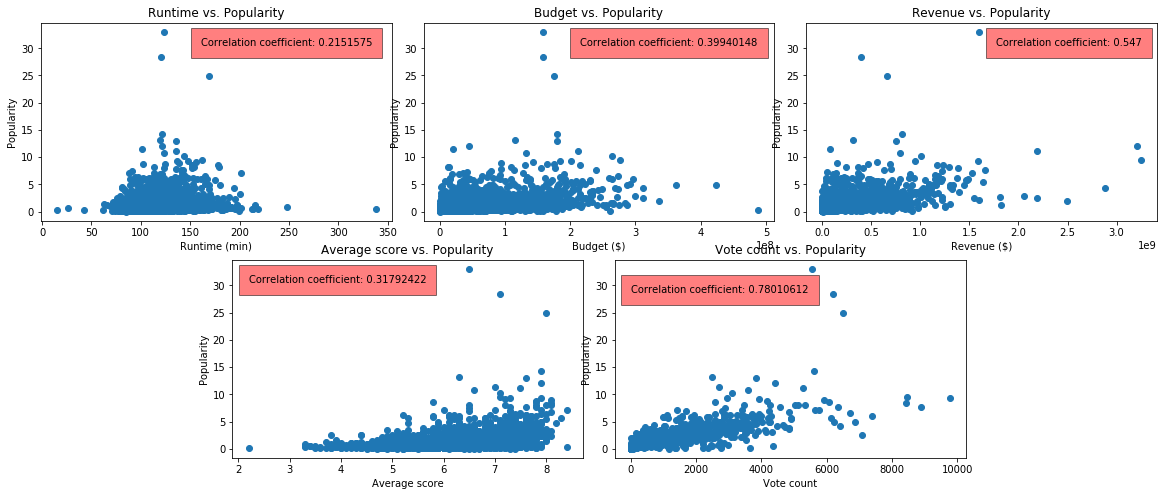

In [20]:
popularity = df['popularity']
runtime = df['runtime']
budget = df['budget_adj']
revenue = df['revenue_adj']
score = df['vote_average']
vote_count = df['vote_count']
release_year = df['release_year']


fig = plt.figure(figsize=(20,8))

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

ax1.scatter(runtime, popularity)
ax1.set_title('Runtime vs. Popularity')
ax1.set_xlabel('Runtime (min)')
ax1.set_ylabel('Popularity')
corrcoef_ax1 = np.corrcoef(runtime, popularity)[1,0]
ax1.text(0.70, 0.9, 'Correlation coefficient: '+np.array2string(corrcoef_ax1),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax1.transAxes,
         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10});

ax2.scatter(budget, popularity)
ax2.set_title('Budget vs. Popularity')
ax2.set_xlabel('Budget ($)')
ax2.set_ylabel('Popularity')
corrcoef_ax2 = np.corrcoef(budget, popularity)[1,0]
ax2.text(0.70, 0.9, 'Correlation coefficient: '+np.array2string(corrcoef_ax2),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax2.transAxes,
         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10});

ax3.scatter(revenue, popularity)
ax3.set_title('Revenue vs. Popularity')
ax3.set_xlabel('Revenue ($)')
ax3.set_ylabel('Popularity')
corrcoef_ax3 = np.corrcoef(revenue, popularity)[1,0]
ax3.text(0.75, 0.9, 'Correlation coefficient: '+np.array2string(corrcoef_ax3),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax3.transAxes,
         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10});

ax4.scatter(score, popularity)
ax4.set_title('Average score vs. Popularity')
ax4.set_xlabel('Average score')
ax4.set_ylabel('Popularity')
corrcoef_ax4 = np.corrcoef(score, popularity)[1,0]
ax4.text(0.3, 0.9, 'Correlation coefficient: '+np.array2string(corrcoef_ax4),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax4.transAxes,
         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10});

ax5.scatter(vote_count, popularity)
ax5.set_title('Vote count vs. Popularity')
ax5.set_xlabel('Vote count')
ax5.set_ylabel('Popularity')
corrcoef_ax5 = np.corrcoef(vote_count, popularity)[1,0]
ax5.text(0.3, 0.85, 'Correlation coefficient: '+np.array2string(corrcoef_ax5),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax5.transAxes,
         bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10});


<a id='conclusions'></a>
## Conclusions

#### Does the average budget increase as time increases? By how much? When adjusting the budget for inflation, does it still increase in time?

We will examine the Average movie budget figure. When looking at the average budget there is a clear upwards trend. Meaning movies budgets increase as time increases.
When adjusting for inflation the same trend can be witnessed. This is confirmed by the high correlation coefficient of the average budget line graph: 0.93.

If we examine the line graph of the average movie budget adjusted for inflation (yellow line) more closely, there is a spike in budget during 1962-1968.
The spike is probably caused by two factors. The first being that we have made the decision to delete all rows with missing data, or where the budget equals zero.
The movie entries that got deleted were probably mostly older movies, as they have a higher chance to have incomplete data. The older movies that did remain
are probably the more well know and thus expensive movies. Which explains this spike.
When adjusting for inflation the spike gets magnified even more, which is why it appears more dramatic than it actually is.
Because of these reasons we can not conclude anything out of this sudden increase in budget.

When looking at the Number of movies per year (1960-2015) figure, we can conclude that as time passes, more movies are getting made. 

#### Is there a positive correlation between budget and average score? Is there between budget and popularity?

The Average score vs. Budget graph is clearly normally distributed. The correlation coefficient is also extremely low (0.037). We can conclude that there is absolutely no correlation between the average score and the budget.

The Popularity vs. Budget graph is a bit more skewed to the right. But the correlation coefficient is also very low (0.40). Here we can also conclude that there is no correlation between popularity and budget.

If we take a closer look at the Average voting score for a movie figure we can clearly see that the average voting score is distributed normally.

When looking at the Popularity of a movie figure, we can conclude that is heavily skewed to the right.

#### What kind of properties are associated with highly popular movies?

Using scatterplots and correlation coefficients should enable us to examine which properties are associated with popularity. All properties appear to have very low correlation coefficients. This can also be seen by looking at the scatter plots.

The only property with a high correlation coefficient is vote count. Which again, can also be seen by looking at the scatter plot. We do not have sufficient information to conclude if higher votes cause more popular movies or if popular movies cause higher vote counts. 

### Limitations

The original data has a bit more than 10 000 entries. After the data cleaning process only 3855 entries remain. Estimates are that currently more than 500 000 movies exist ([source](https://www.quora.com/How-many-movies-cinema-productions-are-there-in-the-world)), which is probably an understatement. Our 3855 is only a sample size of 0.77%. Which is very small.

